# **Part 1A: Machine Learning for Predicting Bone Metastasis in Hepatocellular Carcinoma Using SEER Data**



The overarching goal of this study is to develop robust and clinically actionable predictive models for detecting lung metastasis in hepatocellular carcinoma (HCC) patients using the SEER database. 

### Why This is Important
- **Early Detection**: Metastasis significantly impacts patient prognosis and survival. Identifying high-risk patients early enables timely interventions, which can improve outcomes.
- **Personalized Treatment**: Accurate prediction of metastasis can guide clinicians in tailoring treatment plans, including surgical, chemotherapeutic, and palliative strategies.
- **Resource Optimization**: Predictive models can help prioritize diagnostic imaging and interventions for patients most at risk, optimizing healthcare reso cancer care.


In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

PyTorch version: 2.5.0+cu118
CUDA is available. PyTorch can use the GPU.
Device name: NVIDIA TITAN X (Pascal)


In [4]:
# Load dataset
data = pd.read_excel(r'SEER_Final.xlsx')

In [5]:
# Combine Derived AJCC T columns
data['Combined_T'] = data['Derived AJCC T, 7th ed (2010-2015)'].where(
    data['Derived AJCC T, 7th ed (2010-2015)'] != 'Blank(s)', 
    data['Derived EOD 2018 T (2018+)']
)

# Combine Derived AJCC N columns
data['Combined_N'] = data['Derived AJCC N, 7th ed (2010-2015)'].where(
    data['Derived AJCC N, 7th ed (2010-2015)'] != 'Blank(s)', 
    data['Derived EOD 2018 N (2018+)']
)

# Drop the original columns
data.drop(columns=[
    'Derived AJCC T, 7th ed (2010-2015)', 
    'Derived EOD 2018 T (2018+)', 
    'Derived AJCC N, 7th ed (2010-2015)', 
    'Derived EOD 2018 N (2018+)'
], inplace=True)

In [6]:
# Simplify column names
data.columns = (
    data.columns
    .str.lower() 
    .str.strip()
    .str.replace(r'[^\w\s]', '', regex=True)
    .str.replace(r'\s+', '_', regex=True)
)

# Print the updated column names to verify
print(data.columns)

Index(['seer_combined_mets_at_dxbone_2010',
       'seer_combined_mets_at_dxlung_2010',
       'age_recode_with_single_ages_and_90', 'sex', 'raceethnicity',
       'origin_recode_nhia_hispanic_nonhisp', 'icdo3_histbehav',
       'year_of_diagnosis', 'year_of_followup_recode',
       'reason_no_cancerdirected_surgery', 'chemotherapy_recode_yes_nounk',
       'time_from_diagnosis_to_treatment_in_days_recode',
       'afp_pretreatment_interpretation_recode_2010',
       'tumor_size_over_time_recode_1988', 'marital_status_at_diagnosis',
       'median_household_income_inflation_adj_to_2022',
       'ruralurban_continuum_code', 'combined_t', 'combined_n'],
      dtype='object')


In [7]:
# Define the mapping of original column names to new names
rename_mapping = {
    'seer_combined_mets_at_dxbone_2010': 'bone_met',
    'seer_combined_mets_at_dxlung_2010': 'lung_met',
    'age_recode_with_single_ages_and_90': 'age',
    'sex': 'sex',
    'raceethnicity': 'ethnicity',
    'origin_recode_nhia_hispanic_nonhisp': 'hispanic',
    'icdo3_histbehav': 'icdo3_histbehav',
    'year_of_diagnosis': 'diagnosis_year',
    'year_of_followup_recode': 'followup_year',
    'reason_no_cancerdirected_surgery': 'surgery',
    'chemotherapy_recode_yes_nounk': 'chemo',
    'time_from_diagnosis_to_treatment_in_days_recode': 'diag_days_to_treatment',
    'afp_pretreatment_interpretation_recode_2010': 'afp_pretreatment',
    'tumor_size_over_time_recode_1988': 'tumor_size',
    'marital_status_at_diagnosis': 'marital_status',
    'median_household_income_inflation_adj_to_2022': 'income',
    'ruralurban_continuum_code': 'rural_urban',
    'combined_t': 'combined_t',
    'combined_n': 'combined_n'
}

# Rename the columns
data.rename(columns=rename_mapping, inplace=True)

# Print the updated column names to verify
print(data.columns)

Index(['bone_met', 'lung_met', 'age', 'sex', 'ethnicity', 'hispanic',
       'icdo3_histbehav', 'diagnosis_year', 'followup_year', 'surgery',
       'chemo', 'diag_days_to_treatment', 'afp_pretreatment', 'tumor_size',
       'marital_status', 'income', 'rural_urban', 'combined_t', 'combined_n'],
      dtype='object')


In [8]:
# Extract the part after "Hepatocellular carcinoma"
data['icdo3_histbehav'] = data['icdo3_histbehav'].str.extract(r'Hepatocellular carcinoma, (.*)')

# Print the updated column to verify
print(data['icdo3_histbehav'].head())

0    NOS
1    NOS
2    NOS
3    NOS
4    NOS
Name: icdo3_histbehav, dtype: object


In [12]:
# Define the file path for saving the Excel file
file_path = r'SEER_Cleaned.xlsx'

# Save the DataFrame as an Excel file
data.to_excel(file_path, index=False)

print(f"Data saved successfully to {file_path}")

Data saved successfully to SEER_Cleaned.xlsx


In [10]:
# Print the values in the 'combined_t' column
print(data['combined_t'].unique())

# Print unique values in the 'combined_n' column
print(data['combined_n'].unique())

# Define custom mappings for T and N staging
t_mapping = {
    'T0': 0,
    'TX': 0.5,
    'T1a': 1,
    'T1': 1.5,
    'T1b': 2,
    'T2': 3,
    'T3NOS': 4,
    'T3': 4,
    'T3a': 4.5,
    'T3b': 5,
    'T4': 6
}

n_mapping = {
    'N0': 0,
    'NX': 0.5,
    'N1': 1
}

# Apply the mappings
data['combined_t'] = data['combined_t'].map(t_mapping)
data['combined_n'] = data['combined_n'].map(n_mapping)

# Print to verify the changes
print(data[['combined_t', 'combined_n']].head())

['T4' 'T1b' 'T1' 'T3b' 'T3a' 'T2' 'TX' 'T1a' 'T3NOS' 'T3' 'T0']
['N0' 'N1' 'NX']
   combined_t  combined_n
0         6.0         0.0
1         2.0         0.0
2         1.5         0.0
3         5.0         0.0
4         4.5         0.0


In [11]:
# Process 'age' column
data['age'] = data['age'].str.extract('(\d+)').astype(int)

# Print the updated 'age' column
print(data['age'])

0        69
1        74
2        75
3        30
4        38
         ..
12941    62
12942    71
12943    73
12944    67
12945    71
Name: age, Length: 12946, dtype: int32


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\grnah\AppData\Local\Temp\ipykernel_43284\3750968906.py:2: SyntaxWarning: invalid escape sequence '\d'
  data['age'] = data['age'].str.extract('(\d+)').astype(int)


In [11]:
# Calculate follow-up duration
data['followup_duration'] = data['followup_year'] - data['diagnosis_year']

# Check the result
print(data[['diagnosis_year', 'followup_year', 'followup_duration']].head())

   diagnosis_year  followup_year  followup_duration
0            2018           2019                  1
1            2021           2021                  0
2            2012           2015                  3
3            2010           2011                  1
4            2010           2012                  2


In [12]:
# Replace 'Unable to calculate' with NaN
data['diag_days_to_treatment'] = pd.to_numeric(data['diag_days_to_treatment'], errors='coerce')

# Check the result
print(data['diag_days_to_treatment'].unique())

[ 32.  29. 170.  nan  35.  42. 190.  12.  52.  40.  48.  20.  58.  49.
  21.  51. 153.  39. 247.  85.  82.  47. 148. 142.   5.   0.  31.  76.
 120. 182.  99.  70.  34.  74.  43.  19. 160.  26. 280.   2.  28.  44.
  62. 158.  41.  77.  71.  16.  84. 172.  55.  15.  13.  24.  94. 103.
 110.  53.  37.  54.   4.  59.  65.  36.  14.  50.  25.  64. 154.  45.
  61.  66. 132.  73. 245.  10.   9. 115.  46. 147. 130.  11.  68. 100.
  56. 178.  57.  27.   6. 106.  67. 420.  96. 137. 496.  22. 104.   8.
 227.  86.  23.  81. 125.  97.  72. 238.  87. 141.  75.  30.  60.  33.
   7.  78. 314. 164. 108.  92. 186. 392. 185.   3. 175. 193. 155. 114.
 109.  83.  98. 188. 144. 206. 105.   1. 124. 113. 145.  63.  69. 282.
 121.  38. 131. 139. 215. 336. 228. 327. 705. 271. 140.  93.  90. 223.
  17. 179. 256. 133. 138. 126. 107. 118. 204. 136. 102. 123.  91. 192.
  89. 116.  80. 273.  95. 343. 111. 129. 242. 195. 201. 221. 143. 666.
 240. 484. 161. 150. 112.  79. 540. 254. 199. 127. 358. 119.  18. 263.
 197. 

In [13]:
# Replace non-numeric values in tumor_size
data['tumor_size'] = pd.to_numeric(data['tumor_size'], errors='coerce')

# Check the result
print(data['tumor_size'].unique())

[193.  23.  13. 124. 154.  nan 140.  25. 112. 129.  35.  90.  50.  49.
  40.  38. 194. 127.  80. 115.  52.  87.  59.  41.  33. 137.  44.  18.
  22.  74.  20. 120.  95.  26. 170.  45.  60.  15.  47.  30.  70.  11.
 150.  68. 121.  77.  54.  69.  17.  27.  42.  36.  28.  83. 104.  34.
  67. 180. 147.  84.  65.  21.  55. 123.  94.  66.  57.  56. 130.  51.
 160.  99.  12.  98.  46. 131.  93.  29.  16.  39.  63. 117.  32.  24.
  72.  85.  14.  10.  19.  82. 122.  43. 110.  37. 128.  53. 190. 159.
  62.  75. 183. 108.  31.  58.  64. 133.  92.  61. 145. 100.  86. 200.
 134. 165. 153. 109.  48. 103.  78.   7. 132.  88.  71.  97.  76. 136.
  73. 116. 143. 158.   6. 114.   5.  96. 149. 174. 135.  91. 175.   9.
 105. 155.  89. 126.   1. 146. 177.   8. 167. 144. 101. 173.  81.  79.
 118. 125. 139. 163. 107. 102. 148. 189. 111. 142. 197. 119. 156. 195.
 176. 157. 138. 141. 106. 184. 182. 151.   4. 171. 192. 186. 113. 166.
 199. 168. 172. 191. 188. 198.   3. 185. 152. 161. 164. 162. 187. 169.
 181. 

In [14]:
# Define the mapping for income
income_mapping = {
    'Unknown/missing/no match/Not 1990-2022': 0,
    '< $40,000': 1,
    '$40,000 - $44,999': 2,
    '$45,000 - $49,999': 3,
    '$50,000 - $54,999': 4,
    '$55,000 - $59,999': 5,
    '$60,000 - $64,999': 6,
    '$65,000 - $69,999': 7,
    '$70,000 - $74,999': 8,
    '$75,000 - $79,999': 9,
    '$80,000 - $84,999': 10,
    '$85,000 - $89,999': 11,
    '$90,000 - $94,999': 12,
    '$95,000 - $99,999': 13,
    '$100,000 - $109,999': 14,
    '$110,000 - $119,999': 15,
    '$120,000+': 16
}

# Apply the mapping to the income column
data['income'] = data['income'].map(income_mapping)

# Verify the transformation
print(data['income'].unique())

[16 13 12 15 14  9 10 11  8  6  7  5  4  3  2  1  0]


In [15]:
print(data['afp_pretreatment'].unique())

# Clean and one-hot encode other categorical columns
data['afp_pretreatment_cleaned'] = data['afp_pretreatment'].replace({
    'Positive/elevated': '2',
    'Negative/normal; within normal limits': '0',
    'Borderline; undetermined if positive or negative': '1',
    'Not documented; Not assessed or unknown if assessed': '-1',
    'Test ordered, results not in chart': '-1',
    'Not applicable: Information not collected for this case': '-1'
})

print(data['afp_pretreatment_cleaned'].unique())

# Drop the original afp_pretreatment column
data = data.drop(columns=['afp_pretreatment'])

['Positive/elevated' 'Not documented; Not assessed or unknown if assessed'
 'Test ordered, results not in chart'
 'Negative/normal; within normal limits'
 'Borderline; undetermined if positive or negative'
 'Not applicable: Information not collected for this case']
['2' '-1' '0' '1']


In [16]:
# Map binary columns to 0 and 1
binary_cols = ['bone_met', 'lung_met']
for col in binary_cols:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

In [17]:
# Include binary_cols in one-hot encoding
categorical_cols = ['sex', 'ethnicity', 'hispanic', 'icdo3_histbehav', 'surgery', 'sex',
                     'chemo', 'afp_pretreatment_cleaned', 'marital_status', 'rural_urban'
                    ]

# One-hot encode all categorical columns
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Check for duplicate column names
duplicate_columns = data.columns[data.columns.duplicated()].tolist()
print("Duplicate columns:", duplicate_columns)

# Drop duplicates if needed
data = data.loc[:, ~data.columns.duplicated()]

# Print to verify
print(data.head())

Duplicate columns: ['sex_Male']
   bone_met  lung_met  age  diagnosis_year  followup_year  \
0         0         1   69            2018           2019   
1         0         0   74            2021           2021   
2         0         0   75            2012           2015   
3         0         0   30            2010           2011   
4         0         0   38            2010           2012   

   diag_days_to_treatment  tumor_size  income  combined_t  combined_n  ...  \
0                    32.0       193.0      16         6.0         0.0  ...   
1                    29.0        23.0      16         2.0         0.0  ...   
2                   170.0        13.0      13         1.5         0.0  ...   
3                     NaN       124.0      12         5.0         0.0  ...   
4                    35.0       154.0      15         4.5         0.0  ...   

   marital_status_Separated  marital_status_Single (never married)  \
0                     False                                  F

In [18]:
# Define the file path for saving the Excel file
file_path = r'C:\Users\Admin\Desktop\SEER\hot_encoding.xlsx'

# Save the DataFrame as an Excel file
data.to_excel(file_path, index=False)

print(f"Data saved successfully to {file_path}")

Data saved successfully to C:\Users\Admin\Desktop\SEER\hot_encoding.xlsx


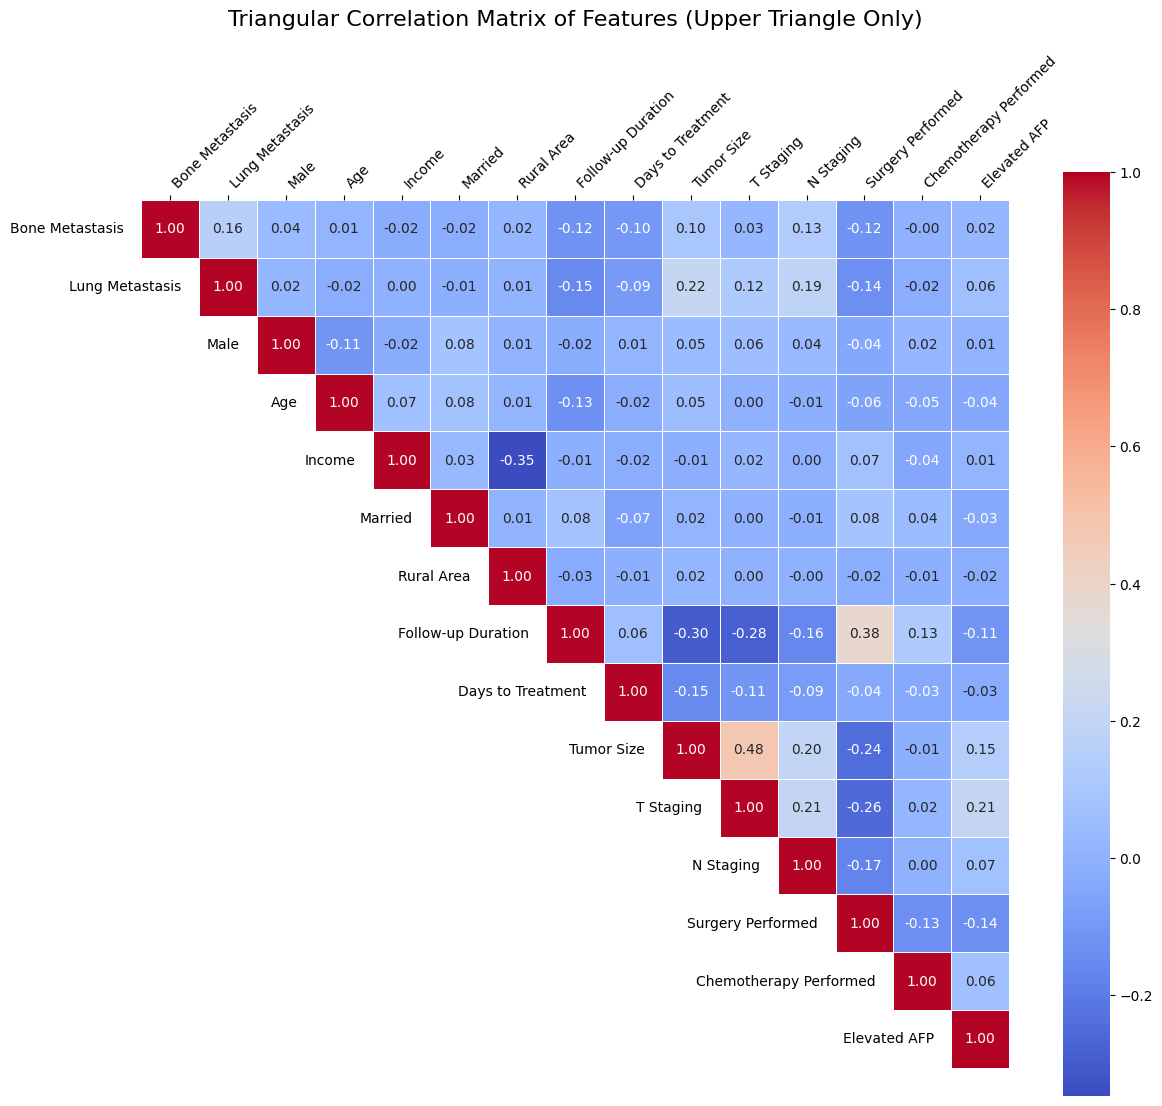

In [19]:
rename_mapping = {
    'bone_met': 'Bone Metastasis',
    'lung_met': 'Lung Metastasis',
    'sex_Male': 'Male',
    'age': 'Age',
    'income': 'Income',
    'marital_status_Married (including common law)': 'Married',
    'rural_urban_Nonmetropolitan counties not adjacent to a metropolitan area': 'Rural Area',
    'followup_duration': 'Follow-up Duration',
    'diag_days_to_treatment': 'Days to Treatment',
    'tumor_size': 'Tumor Size',
    'combined_t': 'T Staging',
    'combined_n': 'N Staging',
    'surgery_Surgery performed': 'Surgery Performed',
    'chemo_Yes': 'Chemotherapy Performed',
    'afp_pretreatment_cleaned_2': 'Elevated AFP',
}

# Subset the columns you want to analyze
columns_of_interest = list(rename_mapping.keys())
data_subset = data[columns_of_interest]

# Compute the correlation matrix
correlation_matrix = data_subset.corr()

# Rename rows and columns for the plot
correlation_matrix = correlation_matrix.rename(index=rename_mapping, columns=rename_mapping)

# Create a mask for the lower triangle
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool), k=-1)

# Set up the figure
plt.figure(figsize=(14, 12))

# Create the heatmap without y-tick labels
sns.heatmap(
    correlation_matrix,
    mask=mask,  # Apply the mask for the lower triangle
    annot=True,  # Add the annotations
    fmt=".2f",   # Set decimal places
    cmap="coolwarm",  # Choose a different color scheme ('coolwarm', 'viridis', 'plasma', 'YlGnBu', etc.)
    cbar=True,        # Show the color bar
    square=True,      # Keep the cells square
    linewidths=0.5,
    xticklabels=True,  # Ensure x-axis labels appear
    yticklabels=False  # Disable default y-axis labels
)

# Adjust x-axis to the top
plt.gca().xaxis.tick_top()
plt.xticks(rotation=45, ha='left', fontsize=10)  # Rotate and align x-axis labels

# Add y-axis labels next to the diagonal manually
for idx, label in enumerate(correlation_matrix.index):
    plt.text(
        idx - 0.3,  # Align with diagonal
        idx + 0.5,        # Vertical alignment
        label,      # Label text
        horizontalalignment='right',
        verticalalignment='center',
        fontsize=10,
        color='black',
        transform=plt.gca().transData
    )

# Adjust title
plt.title("Triangular Correlation Matrix of Features (Upper Triangle Only)", fontsize=16, pad=20)

plt.show()

In [20]:
# Separate features and targets for bone metastasis
X = data.drop(columns=['bone_met', 'lung_met'])
y_bone = data['bone_met']

In [21]:
# Split data for bone metastasis
X_train_bone, X_test_bone, y_train_bone, y_test_bone = train_test_split(X, y_bone, test_size=0.2, random_state=42)

In [22]:
# Impute missing values for all columns
imputer = SimpleImputer(strategy='most_frequent')  # Use 'most_frequent' for categorical data; 'mean' or 'median' for numerical data
X_train_bone = pd.DataFrame(imputer.fit_transform(X_train_bone), columns=X_train_bone.columns)
X_test_bone = pd.DataFrame(imputer.transform(X_test_bone), columns=X_test_bone.columns)

In [23]:
# Drop any remaining non-numeric columns if necessary
data = data.select_dtypes(include=[np.number])

# Apply SMOTE for both bone
sm_bone = SMOTE(random_state=42)
X_resampled_bone, y_resampled_bone = sm_bone.fit_resample(X_train_bone, y_train_bone)

Our objective is to develop predictive models with a recall rate of at least 90% for metastasis detection, ensuring clinical relevance for use by healthcare providers. The optimal threshold was chosen to meet this requirement. We will assess the best-performing model at this threshold, prioritizing comparisons of precision, F1 score, and AUC value to evaluate its overall effectiveness.

**XGBoost**

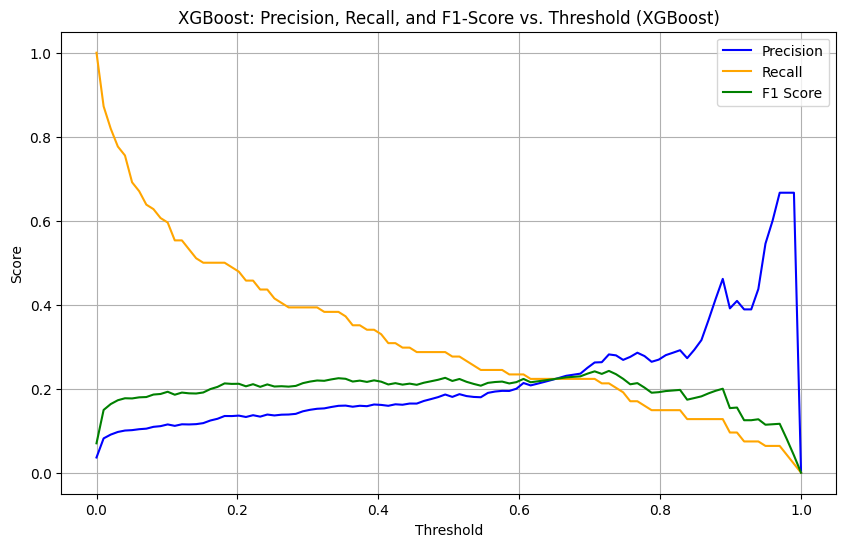

In [24]:
# Train XGBoost model for bone metastasis
xgb_model_bone = XGBClassifier(random_state=42, scale_pos_weight=len(y_train_bone[y_train_bone == 0]) / len(y_train_bone[y_train_bone == 1]))
xgb_model_bone.fit(X_resampled_bone, y_resampled_bone)
y_pred_bone = xgb_model_bone.predict(X_test_bone)
y_proba_bone = xgb_model_bone.predict_proba(X_test_bone)[:, 1]

# Compute precision, recall, and F1 for various thresholds
thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1s = [], [], []

for threshold in thresholds:
    y_pred = (y_proba_bone >= threshold).astype(int)  # Corrected variable name
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_bone, y_pred, average='binary', zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", color="blue")
plt.plot(thresholds, recalls, label="Recall", color="orange")
plt.plot(thresholds, f1s, label="F1 Score", color="green")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("XGBoost: Precision, Recall, and F1-Score vs. Threshold (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

XGBoost Evaluation with optimal threshold = 0.0298:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      2496
           1       0.10      0.80      0.18        94

    accuracy                           0.73      2590
   macro avg       0.54      0.76      0.51      2590
weighted avg       0.96      0.73      0.81      2590

Confusion Matrix:
[[1816  680]
 [  19   75]]
ROC-AUC Score: 0.8259768821603928


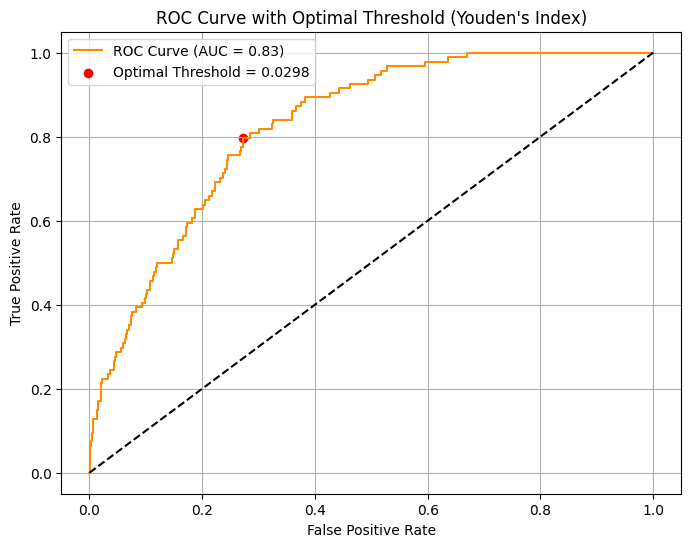

In [25]:


# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_bone, y_proba_bone)

# Find the optimal threshold using Youden's Index
optimal_idx = np.argmax(tpr - fpr)  # Maximizing Sensitivity - (1 - Specificity)
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold
y_pred_custom = (y_proba_bone >= optimal_threshold).astype(int)

# Evaluate performance at this threshold
print(f"XGBoost Evaluation with optimal threshold = {optimal_threshold:.4f}:")
print("Classification Report:")
print(classification_report(y_test_bone, y_pred_custom))
print("Confusion Matrix:")
print(confusion_matrix(y_test_bone, y_pred_custom))
print("ROC-AUC Score:", roc_auc_score(y_test_bone, y_proba_bone))

# Optional: Plot the ROC curve with the optimal threshold highlighted
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test_bone, y_proba_bone):.2f})', color='darkorange')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.4f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Optimal Threshold (Youden's Index)")
plt.legend()
plt.grid(True)
plt.show()

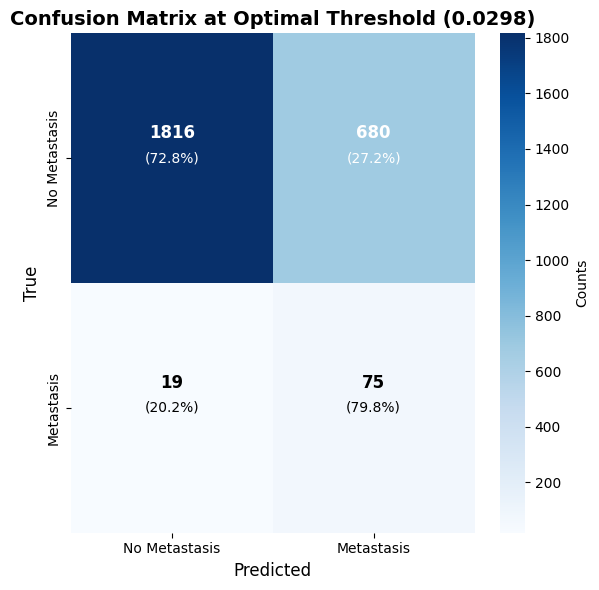

In [26]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_bone, y_proba_bone)

# Find the optimal threshold using Youden's Index
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold
y_pred_custom = (y_proba_bone >= optimal_threshold).astype(int)

# Confusion Matrix at Optimal Threshold
cm = confusion_matrix(y_test_bone, y_pred_custom)
cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100  # Convert to percentages

plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    cm,
    annot=False,  # Disable default annotations to add both counts and percentages manually
    fmt="d",
    cmap="Blues",
    xticklabels=['No Metastasis', 'Metastasis'],
    yticklabels=['No Metastasis', 'Metastasis'],
    cbar_kws={'label': 'Counts'}
)

# Add annotations for counts and percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Determine text color based on cell position
        text_color = "white" if i == 0 else "black"
        # Add raw count
        ax.text(j + 0.5, i + 0.4, f"{cm[i, j]}", 
                ha="center", va="center", color=text_color, fontsize=12, weight="bold")
        # Add percentage below count
        ax.text(j + 0.5, i + 0.5, f"({cm_percentage[i, j]:.1f}%)", 
                ha="center", va="center", color=text_color, fontsize=10)

plt.title(f"Confusion Matrix at Optimal Threshold ({optimal_threshold:.4f})", fontsize=14, fontweight="bold")
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

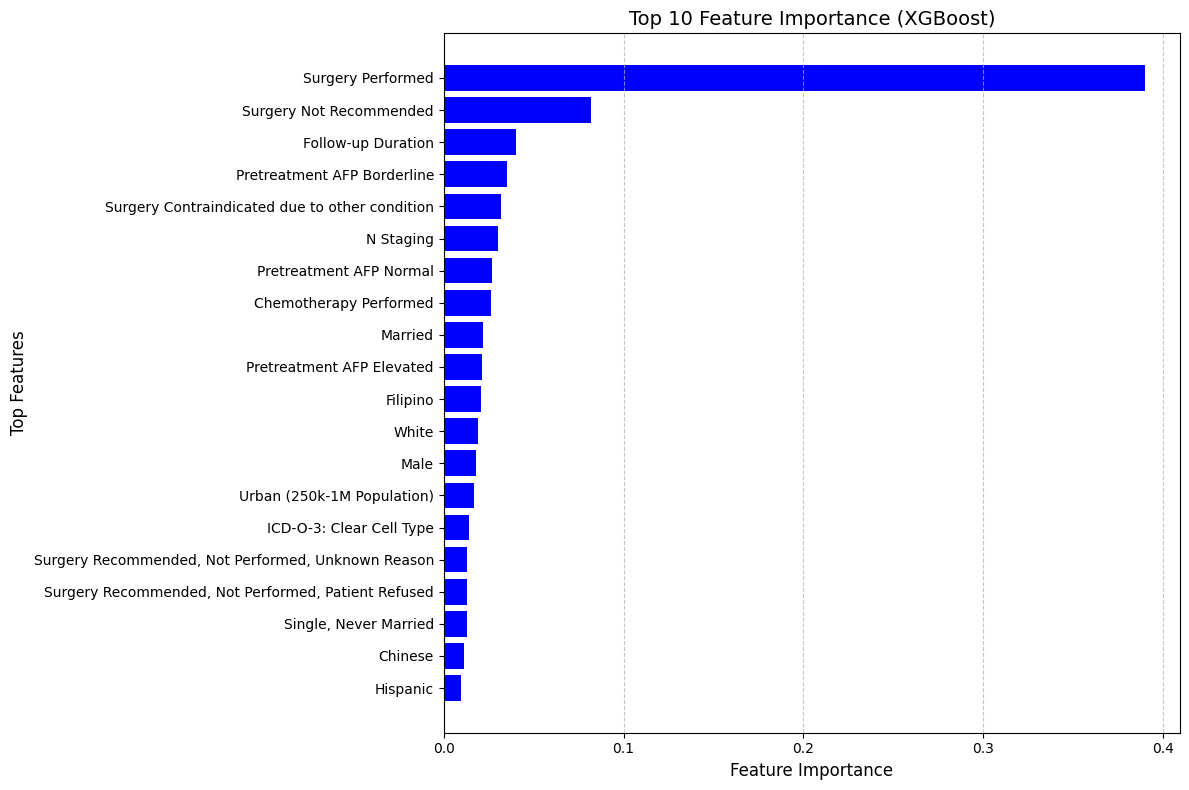

In [27]:
# Extract feature importance and sort indices by descending order
feature_importances = xgb_model_bone.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]  # Sort from highest to lowest

# Get the top 10 features
top_n = 20
top_indices = sorted_indices[:top_n]
top_features = [X_resampled_bone.columns[i] for i in top_indices]
top_importances = feature_importances[top_indices]

# New y-axis labels for the top features
rename_mapping = {
    'surgery_Surgery performed': 'Surgery Performed',
    'surgery_Not recommended': 'Surgery Not Recommended',
    'afp_pretreatment_cleaned_1': 'Pretreatment AFP Borderline',
    'surgery_Not recommended, contraindicated due to other cond; autopsy only (1973-2002)': 'Surgery Contraindicated due to other condition',
    'afp_pretreatment_cleaned_0': 'Pretreatment AFP Normal',
    'afp_pretreatment_cleaned_2': 'Pretreatment AFP Elevated',
    'tumor_size': 'Tumor Size',
    'age': 'Age',
    'diag_days_to_treatment': 'Days to Treatment',
    'combined_t': 'T Staging',
    'income': 'Income',
    'combined_n': 'N Staging',
    'followup_duration': 'Follow-up Duration',
    'marital_status_Married (including common law)': 'Married',
    'chemo_Yes': 'Chemotherapy Performed',
    'ethnicity_Filipino': 'Filipino',
    'ethnicity_White': 'White',
    'sex_Male': 'Male',
    'rural_urban_Counties in metropolitan areas of 250,000 to 1 million pop': 'Urban (250k-1M Population)',
    'rural_urban_Counties in metropolitan areas of lt 250 thousand pop': 'Small Metropolitan Area (<250k Population)',
    'icdo3_histbehav_clear cell type': 'ICD-O-3: Clear Cell Type',
    'surgery_Recommended but not performed, patient refused': 'Surgery Recommended, Not Performed, Patient Refused',
    'surgery_Recommended but not performed, unknown reason': 'Surgery Recommended, Not Performed, Unknown Reason',
    'marital_status_Single (never married)': 'Single, Never Married',
    'ethnicity_Chinese': 'Chinese',
    'hispanic_Spanish-Hispanic-Latino': 'Hispanic',
    'diagnosis_year': 'Diagnosis Year',
    'ethnicity_Black': 'Black',
    'followup_year': 'Follow-up Year',
    'marital_status_Widowed': 'Widowed',
    'ethnicity_Vietnamese (1988+)': 'Vietnamese',
    
}
top_features_renamed = [rename_mapping.get(feature, feature) for feature in top_features]

# Plot the top 10 feature importance as a horizontal bar plot
plt.figure(figsize=(12, 8))  # Increased width for a longer graph
plt.barh(top_features_renamed, top_importances, color="blue")
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Top Features", fontsize=12)
plt.title("Top 10 Feature Importance (XGBoost)", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top

# Add grid and ticks for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Set x-axis ticks to whole numbers (0.1, 0.2, etc.)
plt.xticks(np.arange(0, round(max(top_importances) + 0.1, 1), 0.1))  # Dynamic ticks rounded to nearest 0.1

plt.tight_layout()
plt.show()

**Random Forest**

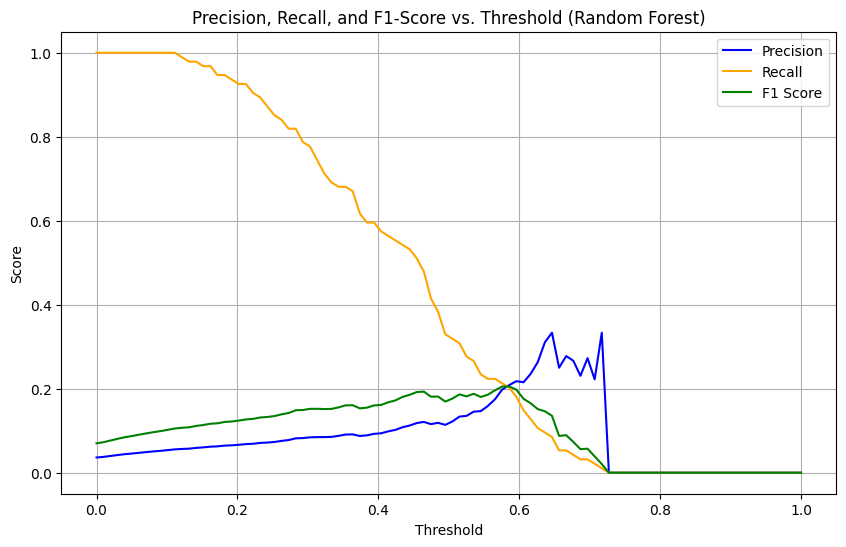

In [28]:
# Train Random Forest for bone metastasis
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=200, max_depth=7)
rf_model.fit(X_resampled_bone, y_resampled_bone)
y_pred_rf = rf_model.predict(X_test_bone)
y_proba_rf = rf_model.predict_proba(X_test_bone)[:, 1]

# Compute precision, recall, and F1 for various thresholds
thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1s = [], [], []

for threshold in thresholds:
    y_pred = (y_proba_rf >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_bone, y_pred, average='binary', zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", color="blue")
plt.plot(thresholds, recalls, label="Recall", color="orange")
plt.plot(thresholds, f1s, label="F1 Score", color="green")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs. Threshold (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()

Random Forest Evaluation with optimal threshold = 0.2843:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      2496
           1       0.08      0.82      0.15        94

    accuracy                           0.66      2590
   macro avg       0.54      0.74      0.47      2590
weighted avg       0.96      0.66      0.77      2590

Confusion Matrix:
[[1638  858]
 [  17   77]]
ROC-AUC Score: 0.8029826445717403


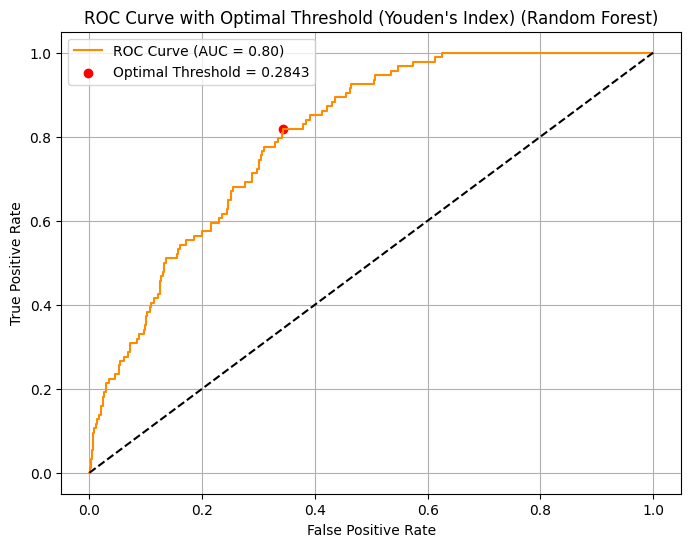

In [29]:
# Calculate the ROC curve for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_bone, y_proba_rf)

# Find the optimal threshold using Youden's Index
optimal_idx_rf = np.argmax(tpr_rf - fpr_rf)
optimal_threshold_rf = thresholds_rf[optimal_idx_rf]

# Apply the optimal threshold
y_pred_rf_custom = (y_proba_rf >= optimal_threshold_rf).astype(int)

# Evaluate performance at this threshold
print(f"Random Forest Evaluation with optimal threshold = {optimal_threshold_rf:.4f}:")
print("Classification Report:")
print(classification_report(y_test_bone, y_pred_rf_custom))
print("Confusion Matrix:")
print(confusion_matrix(y_test_bone, y_pred_rf_custom))
print("ROC-AUC Score:", roc_auc_score(y_test_bone, y_proba_rf))

# Plot the ROC curve with the optimal threshold highlighted
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'ROC Curve (AUC = {roc_auc_score(y_test_bone, y_proba_rf):.2f})', color='darkorange')
plt.scatter(fpr_rf[optimal_idx_rf], tpr_rf[optimal_idx_rf], color='red', label=f'Optimal Threshold = {optimal_threshold_rf:.4f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Optimal Threshold (Youden's Index) (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()

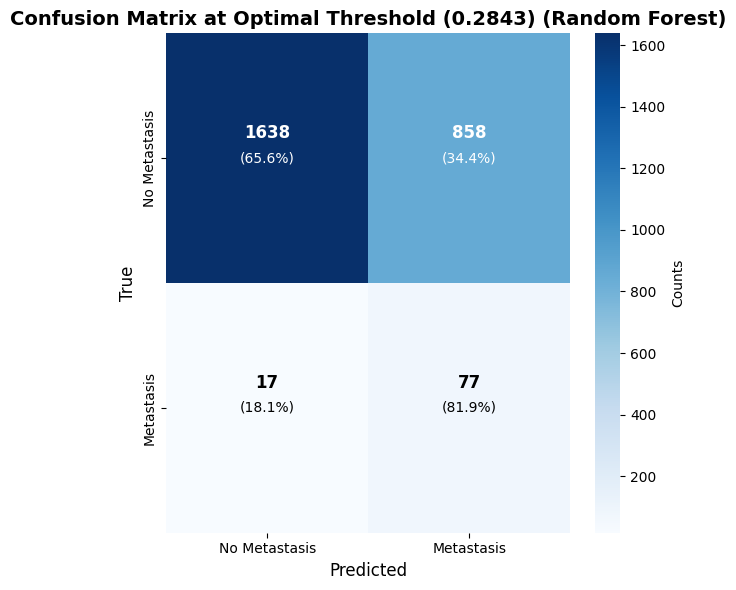

In [30]:
# Confusion Matrix at Optimal Threshold
cm_rf = confusion_matrix(y_test_bone, y_pred_rf_custom)
cm_percentage_rf = cm_rf / cm_rf.sum(axis=1, keepdims=True) * 100  # Convert to percentages

plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    cm_rf,
    annot=False,  # Disable default annotations to add both counts and percentages manually
    fmt="d",
    cmap="Blues",
    xticklabels=['No Metastasis', 'Metastasis'],
    yticklabels=['No Metastasis', 'Metastasis'],
    cbar_kws={'label': 'Counts'}
)

# Add annotations for counts and percentages
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        # Determine text color based on cell position
        text_color = "white" if i == 0 else "black"
        # Add raw count
        ax.text(j + 0.5, i + 0.4, f"{cm_rf[i, j]}", 
                ha="center", va="center", color=text_color, fontsize=12, weight="bold")
        # Add percentage below count
        ax.text(j + 0.5, i + 0.5, f"({cm_percentage_rf[i, j]:.1f}%)", 
                ha="center", va="center", color=text_color, fontsize=10)

plt.title(f"Confusion Matrix at Optimal Threshold ({optimal_threshold_rf:.4f}) (Random Forest)", fontsize=14, fontweight="bold")
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

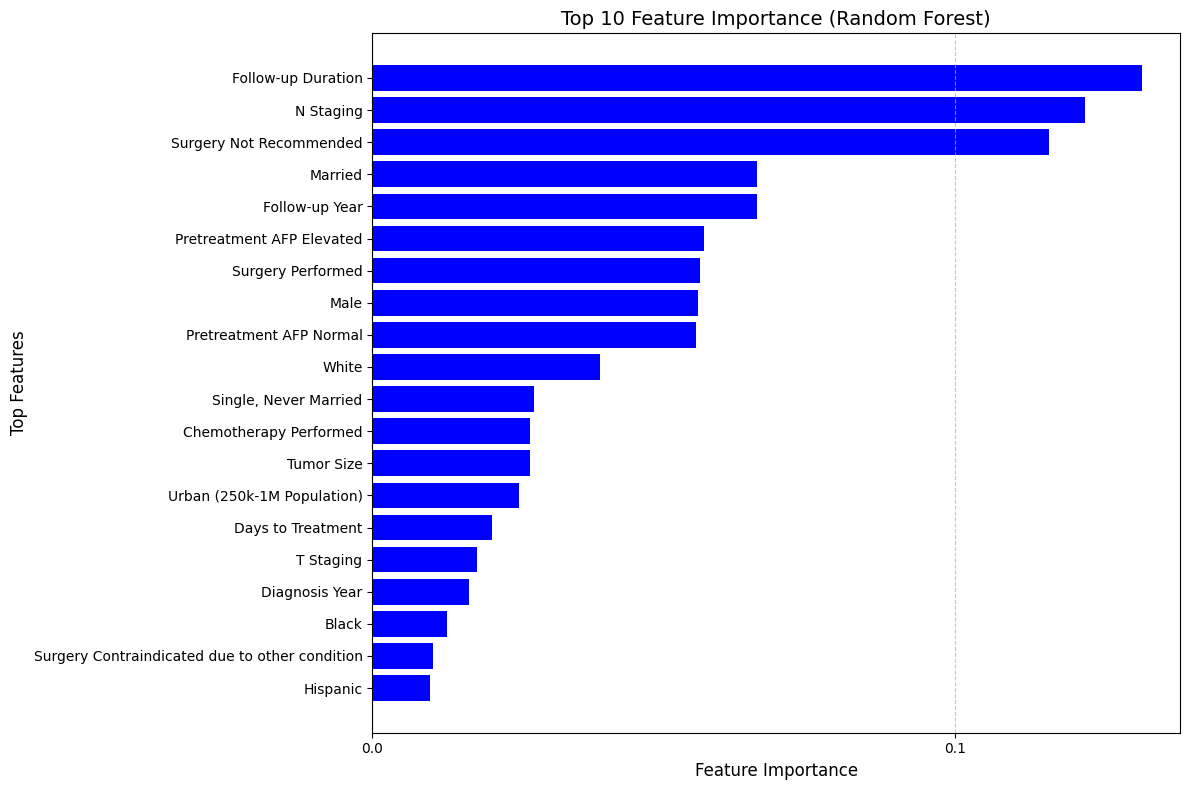

In [31]:
# Extract feature importance and sort indices by descending order
feature_importances_rf = rf_model.feature_importances_
sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]  # Sort from highest to lowest

# Get the top 10 features
top_n_rf = 20
top_indices_rf = sorted_indices_rf[:top_n_rf]
top_features_rf = [X_resampled_bone.columns[i] for i in top_indices_rf]
top_importances_rf = feature_importances_rf[top_indices_rf]

# Rename top features for better readability
top_features_renamed_rf = [rename_mapping.get(feature, feature) for feature in top_features_rf]

# Plot the top 10 feature importance as a horizontal bar plot
plt.figure(figsize=(12, 8))  # Increased width for a longer graph
plt.barh(top_features_renamed_rf, top_importances_rf, color="blue")
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Top Features", fontsize=12)
plt.title("Top 10 Feature Importance (Random Forest)", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top

# Add grid and ticks for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Set x-axis ticks to whole numbers (0.1, 0.2, etc.)
plt.xticks(np.arange(0, round(max(top_importances_rf) + 0.1, 1), 0.1))  # Dynamic ticks rounded to nearest 0.1

plt.tight_layout()
plt.show()

**Logistic Regression**

C:\Users\Admin\anaconda3\envs\deep_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


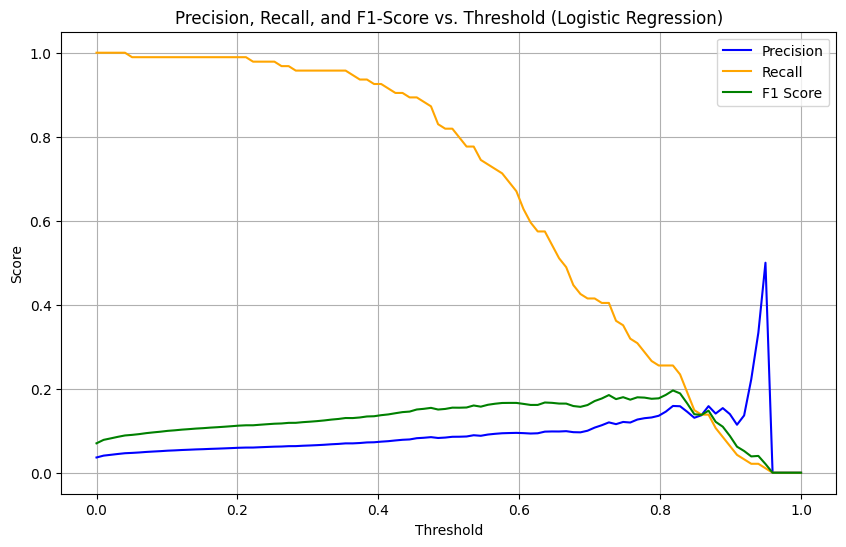

In [32]:
# Train Logistic Regression for bone metastasis
lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500)
lr_model.fit(X_resampled_bone, y_resampled_bone)

# Predict probabilities for bone metastasis
y_pred_lr = rf_model.predict(X_test_bone)
y_proba_lr = lr_model.predict_proba(X_test_bone)[:, 1]

# Compute precision, recall, and F1 for various thresholds
thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1s = [], [], []

for threshold in thresholds:
    y_pred = (y_proba_lr >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_bone, y_pred, average='binary', zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", color="blue")
plt.plot(thresholds, recalls, label="Recall", color="orange")
plt.plot(thresholds, f1s, label="F1 Score", color="green")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs. Threshold (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

Logistic Regression Evaluation with optimal threshold = 0.4619:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      2496
           1       0.08      0.89      0.15        94

    accuracy                           0.64      2590
   macro avg       0.54      0.76      0.46      2590
weighted avg       0.96      0.64      0.75      2590

Confusion Matrix:
[[1579  917]
 [  10   84]]
ROC-AUC Score: 0.8068313557010366


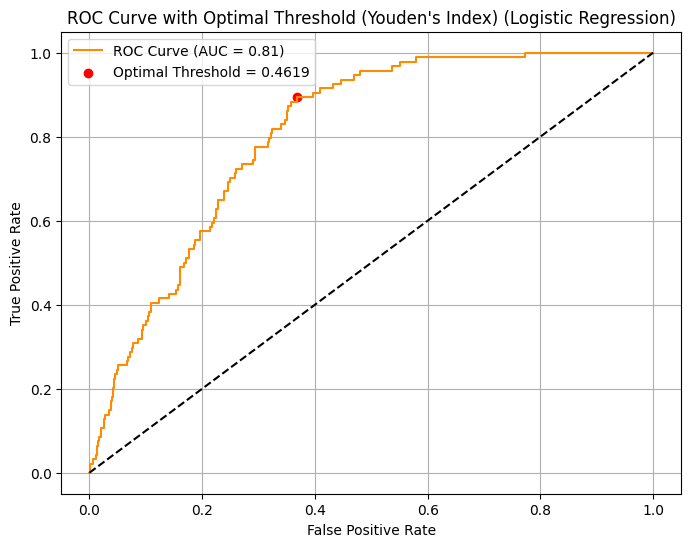

In [33]:
# Calculate the ROC curve for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_bone, y_proba_lr)

# Find the optimal threshold using Youden's Index
optimal_idx_lr = np.argmax(tpr_lr - fpr_lr)
optimal_threshold_lr = thresholds_lr[optimal_idx_lr]

# Apply the optimal threshold
y_pred_lr_custom = (y_proba_lr >= optimal_threshold_lr).astype(int)

# Evaluate performance at this threshold
print(f"Logistic Regression Evaluation with optimal threshold = {optimal_threshold_lr:.4f}:")
print("Classification Report:")
print(classification_report(y_test_bone, y_pred_lr_custom))
print("Confusion Matrix:")
print(confusion_matrix(y_test_bone, y_pred_lr_custom))
print("ROC-AUC Score:", roc_auc_score(y_test_bone, y_proba_lr))

# Plot the ROC curve with the optimal threshold highlighted
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'ROC Curve (AUC = {roc_auc_score(y_test_bone, y_proba_lr):.2f})', color='darkorange')
plt.scatter(fpr_lr[optimal_idx_lr], tpr_lr[optimal_idx_lr], color='red', label=f'Optimal Threshold = {optimal_threshold_lr:.4f}')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Optimal Threshold (Youden's Index) (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

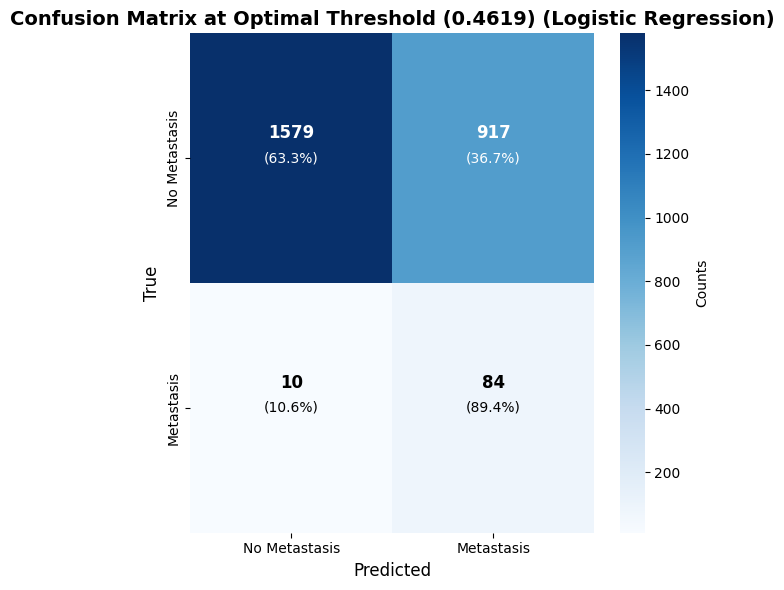

In [34]:
# Confusion Matrix at Optimal Threshold
cm_lr = confusion_matrix(y_test_bone, y_pred_lr_custom)
cm_percentage_lr = cm_lr / cm_lr.sum(axis=1, keepdims=True) * 100  # Convert to percentages

plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    cm_lr,
    annot=False,  # Disable default annotations to add both counts and percentages manually
    fmt="d",
    cmap="Blues",
    xticklabels=['No Metastasis', 'Metastasis'],
    yticklabels=['No Metastasis', 'Metastasis'],
    cbar_kws={'label': 'Counts'}
)

# Add annotations for counts and percentages
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        # Determine text color based on cell position
        text_color = "white" if i == 0 else "black"
        # Add raw count
        ax.text(j + 0.5, i + 0.4, f"{cm_lr[i, j]}", 
                ha="center", va="center", color=text_color, fontsize=12, weight="bold")
        # Add percentage below count
        ax.text(j + 0.5, i + 0.5, f"({cm_percentage_lr[i, j]:.1f}%)", 
                ha="center", va="center", color=text_color, fontsize=10)

plt.title(f"Confusion Matrix at Optimal Threshold ({optimal_threshold_lr:.4f}) (Logistic Regression)", fontsize=14, fontweight="bold")
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

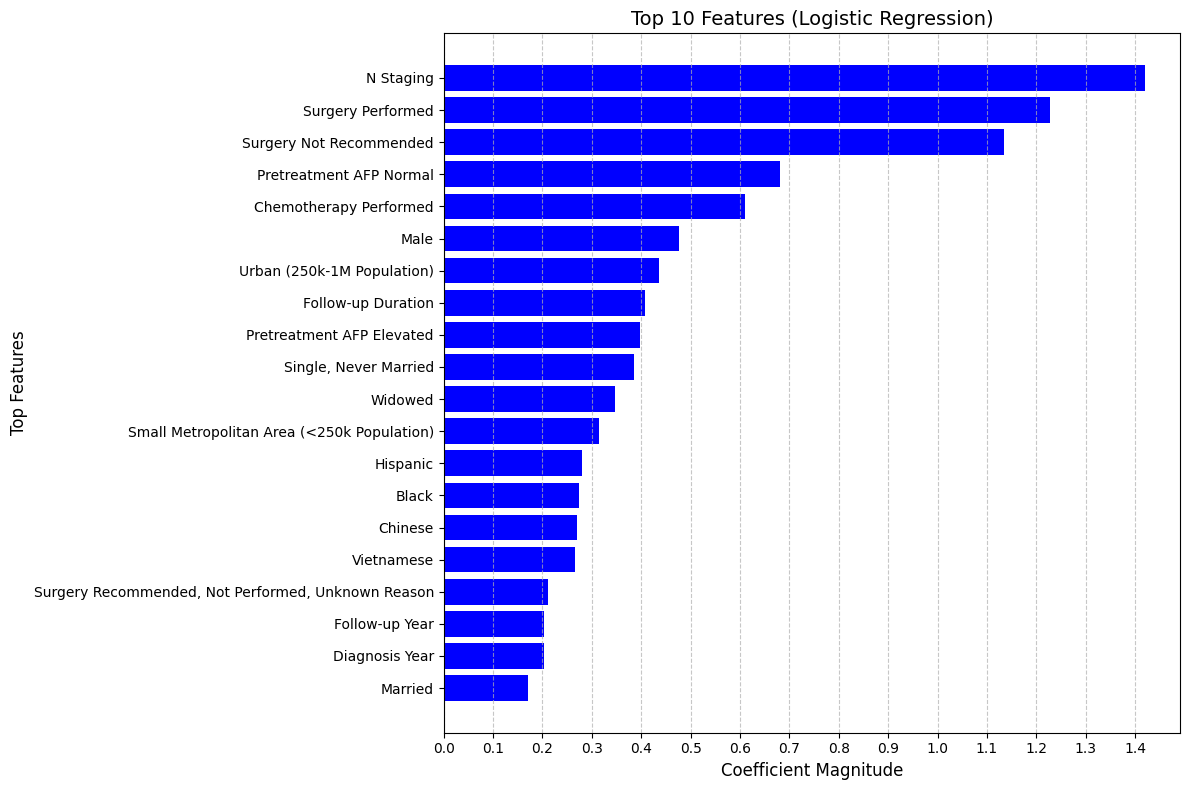

In [35]:
# Extract coefficients and sort by absolute value
coefficients_lr = np.abs(lr_model.coef_[0])  # Get absolute values of coefficients
sorted_indices_lr = np.argsort(coefficients_lr)[::-1]  # Sort from highest to lowest

# Get the top 10 features
top_n_lr = 20
top_indices_lr = sorted_indices_lr[:top_n_lr]
top_features_lr = [X_resampled_bone.columns[i] for i in top_indices_lr]
top_coefficients_lr = coefficients_lr[top_indices_lr]

# Rename top features for better readability
top_features_renamed_lr = [rename_mapping.get(feature, feature) for feature in top_features_lr]

# Plot the top 10 feature coefficients as a horizontal bar plot
plt.figure(figsize=(12, 8))  # Increased width for a longer graph
plt.barh(top_features_renamed_lr, top_coefficients_lr, color="blue")
plt.xlabel("Coefficient Magnitude", fontsize=12)
plt.ylabel("Top Features", fontsize=12)
plt.title("Top 10 Features (Logistic Regression)", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top

# Add grid and ticks for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Set x-axis ticks to whole numbers (0.1, 0.2, etc.)
plt.xticks(np.arange(0, round(max(top_coefficients_lr) + 0.1, 1), 0.1))  # Dynamic ticks rounded to nearest 0.1

plt.tight_layout()
plt.show()

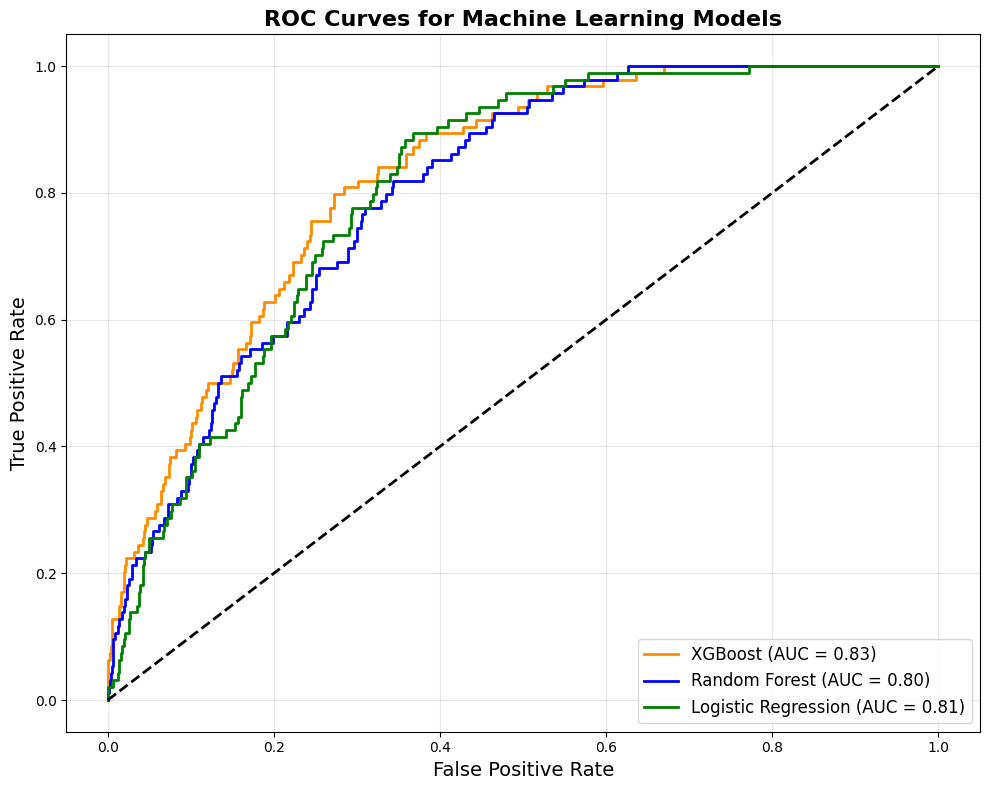

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC metrics and AUC scores for each model
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_bone, y_proba_bone)
auc_xgb = roc_auc_score(y_test_bone, y_proba_bone)

fpr_rf, tpr_rf, _ = roc_curve(y_test_bone, y_proba_rf)
auc_rf = roc_auc_score(y_test_bone, y_proba_rf)

fpr_lr, tpr_lr, _ = roc_curve(y_test_bone, y_proba_lr)
auc_lr = roc_auc_score(y_test_bone, y_proba_lr)

# Plot all ROC curves on the same plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})", color="darkorange", lw=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color="blue", lw=2)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})", color="green", lw=2)

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color="black", linestyle="--", lw=2)

# Customize plot appearance
plt.title("ROC Curves for Machine Learning Models", fontsize=16, fontweight="bold")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()


**Deep Learning (Neural Network)**

In [37]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bone)
X_test_scaled = scaler.transform(X_test_bone)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bone.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_bone.values, dtype=torch.float32)

# Calculate positive class weight for imbalanced datasets
positive_samples = y_train_tensor.sum().item()
negative_samples = len(y_train_tensor) - positive_samples
pos_weight = negative_samples / positive_samples
pos_weight_tensor = torch.tensor([pos_weight], dtype=torch.float32)

# Define the CNN model
class CNN1D(nn.Module):
    def __init__(self, input_size):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * input_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
cnn_model = CNN1D(input_size)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-5)

# Split the data into training and validation sets
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.2, random_state=42, stratify=y_train_tensor
)

# Training loop with early stopping
num_epochs = 100
batch_size = 64
patience = 10
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    cnn_model.train()
    permutation = torch.randperm(X_train_main.size(0))
    epoch_loss = 0.0

    for i in range(0, X_train_main.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_main[indices], y_train_main[indices]

        optimizer.zero_grad()
        outputs = cnn_model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)

    epoch_loss /= X_train_main.size(0)

    # Validation
    cnn_model.eval()
    with torch.no_grad():
        val_outputs = cnn_model(X_val).squeeze()
        val_loss = criterion(val_outputs, y_val).item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        best_model_state = cnn_model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print('Early stopping!')
            break

# Load the best model state
cnn_model.load_state_dict(best_model_state)

# Evaluate the model on the test set
cnn_model.eval()
with torch.no_grad():
    test_outputs = cnn_model(X_test_tensor).squeeze()
    y_pred_proba_cnn = torch.sigmoid(test_outputs).numpy()
    y_test_np = y_test_tensor.numpy()

# Find the optimal threshold using the ROC curve
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test_np, y_pred_proba_cnn)
optimal_idx_cnn = np.argmax(tpr_cnn - fpr_cnn)
optimal_threshold_cnn = thresholds_cnn[optimal_idx_cnn]
print(f'Optimal Threshold: {optimal_threshold_cnn:.4f}')

# Apply the optimal threshold
y_pred_cnn = (y_pred_proba_cnn >= optimal_threshold_cnn).astype(int)

# Print evaluation metrics
print("Bone Metastasis Prediction with CNN:")
print(classification_report(y_test_np, y_pred_cnn))
print("ROC-AUC Score:", roc_auc_score(y_test_np, y_pred_proba_cnn))
print("Confusion Matrix:\n", confusion_matrix(y_test_np, y_pred_cnn))

Epoch [1/100], Train Loss: 1.1727, Validation Loss: 1.0958
Epoch [2/100], Train Loss: 1.0620, Validation Loss: 1.0081
Epoch [3/100], Train Loss: 1.0180, Validation Loss: 1.0135
Epoch [4/100], Train Loss: 1.0101, Validation Loss: 1.0085
Epoch [5/100], Train Loss: 0.9930, Validation Loss: 1.0196
Epoch [6/100], Train Loss: 0.9586, Validation Loss: 1.0126
Epoch [7/100], Train Loss: 0.9501, Validation Loss: 1.0794
Epoch [8/100], Train Loss: 0.9640, Validation Loss: 1.0132
Epoch [9/100], Train Loss: 0.9318, Validation Loss: 1.0085
Epoch [10/100], Train Loss: 0.9213, Validation Loss: 1.0123
Epoch [11/100], Train Loss: 0.9194, Validation Loss: 1.0238
Epoch [12/100], Train Loss: 0.9013, Validation Loss: 1.0678
Early stopping!
Optimal Threshold: 0.3559
Bone Metastasis Prediction with CNN:
              precision    recall  f1-score   support

         0.0       0.99      0.58      0.73      2496
         1.0       0.08      0.91      0.14        94

    accuracy                           0.59   

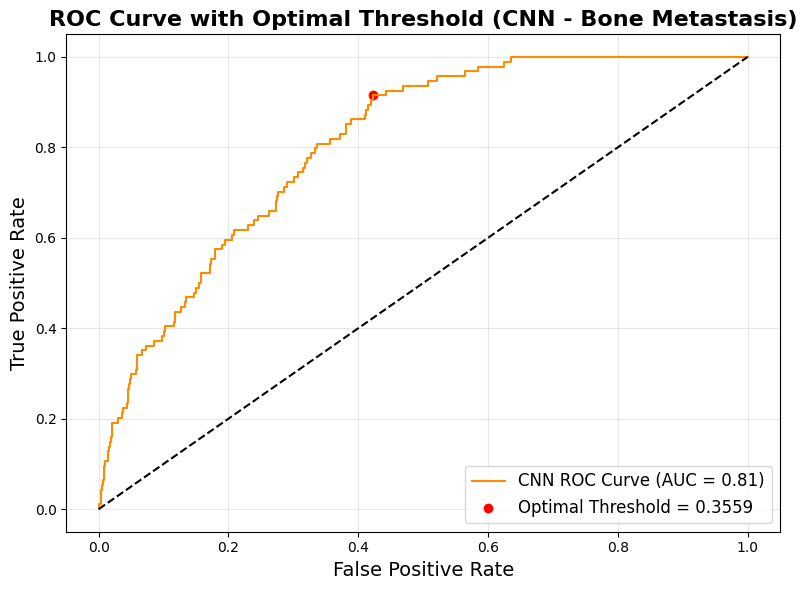

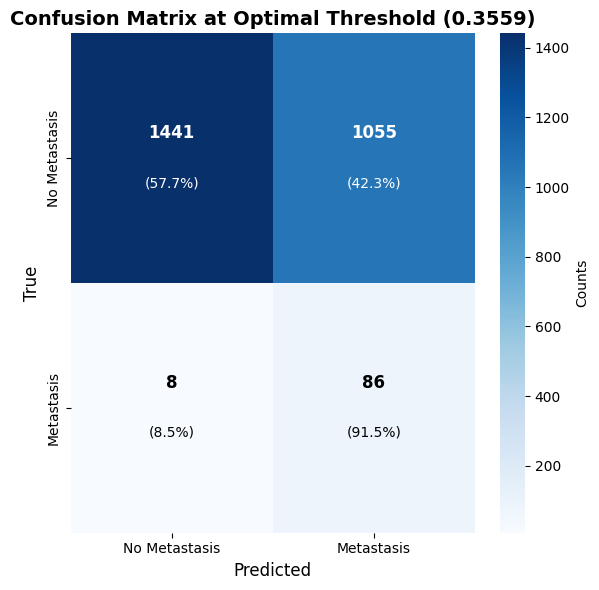

In [38]:
# ROC Curve Plot for CNN
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN ROC Curve (AUC = {roc_auc_score(y_test_np, y_pred_proba_cnn):.2f})", color="darkorange")
plt.scatter(fpr_cnn[optimal_idx_cnn], tpr_cnn[optimal_idx_cnn], color="red", label=f"Optimal Threshold = {optimal_threshold_cnn:.4f}")
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve with Optimal Threshold (CNN - Bone Metastasis)", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion Matrix Plot for CNN
cm_cnn = confusion_matrix(y_test_np, y_pred_cnn)
cm_cnn_percentage = cm_cnn / cm_cnn.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    cm_cnn,
    annot=False,  # Disable default annotations for manual addition
    fmt="d",
    cmap="Blues",
    xticklabels=["No Metastasis", "Metastasis"],
    yticklabels=["No Metastasis", "Metastasis"],
    cbar_kws={"label": "Counts"},
)

# Annotate Confusion Matrix
for i in range(cm_cnn.shape[0]):
    for j in range(cm_cnn.shape[1]):
        text_color = "white" if i == 0 else "black"
        # Add raw count
        ax.text(j + 0.5, i + 0.4, f"{cm_cnn[i, j]}", ha="center", va="center", color=text_color, fontsize=12, weight="bold")
        # Add percentage below count
        ax.text(j + 0.5, i + 0.6, f"({cm_cnn_percentage[i, j]:.1f}%)", ha="center", va="center", color=text_color, fontsize=10)

plt.title(f"Confusion Matrix at Optimal Threshold ({optimal_threshold_cnn:.4f})", fontsize=14, fontweight="bold")
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.tight_layout()
plt.show()